# cooking the best possible web search result

We currently have a nice web search report capability, that generates a rich Markdown document containing the search results.

But what if we just want a simple answer to a given query? say "give me the ticker symbol of the leading cie in yoghurts"

We'd need another workflow for that. The algorithm would be the following:

**main loop**

- start with a graph state having keys:
  - `attempts_count`
  - `num_web_search_queries`
  - `searches_summary`
  - `searched_queries`
  - `searched_urls`
- generate x queries with the initial query
- update the state: 
  - add the queries to the `searched_queries` list
  - add the urls to the `searched_urls` list
- search the web using each of the queries and concatenate the results
  - skip any url that has already been searched without making less searches
- write a summary of the search results `searches_summary` using a LLM
  - should show the query, the results and the sources of the results
- attempt to derive the information we need from the concatenated results
- increment the `attempts_count`

**if success**

- return the answer as a JSON having key `answer`

**if failure**

- return the answer as a JSON having key `answer` with value `null`
- generate x new queries:
  - tell the LLM which query is the original query
  - tell the LLM which queries have already been tried, and should not be tried again
  - give the LLM the `searches_summary`
  - tell the LLM to generate x new queries
- re do the main loop with the new queries until we succeed or run out of attempts


## Initialize graph state

- start with a graph state having keys:
  - `attempts_count`
  - `num_web_search_queries`
  - `searches_summary`
  - `searched_queries`
  - `searched_urls`

In [1]:
user_query = "give me the ticker symbol of the leading company in yoghurts"

In [2]:
from langgraph.graph import MessagesState


# remember that `MessagesState` has a built-in `messages` key
class State(MessagesState):
    attempts_count: int
    num_web_search_queries: int
    searches_summary: str
    searched_queries: list[str]
    searched_urls: list[str]

## generate x queries with the initial query

In [3]:
from agentic_search.chains.web import get_web_search_queries_chain

queries_generation_res = get_web_search_queries_chain().invoke({"query": user_query, "x": 3})
queries_generation_res


{'queries': ['leading yogurt company stock symbol',
  'largest dairy company by market cap ticker',
  'top yogurt brand market share and stock symbol']}

## TODO: update the state: add the queries to the `searched_queries` list and the urls to the `searched_urls` list

In [4]:
def generate_web_search_queries_node(state: State):
    user_query_message = state["messages"][-1]
    res = get_web_search_queries_chain().invoke({"query": user_query_message, "x": state["num_web_search_queries"]})
    return {
        "searched_queries": state["searched_queries"] + res["queries"],
    }

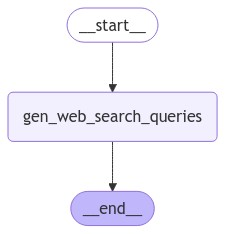

In [5]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START


def get_web_search_graph_v1(display_graph: bool = False):
    # Define a new graph
    workflow = StateGraph(State)
    workflow.add_node("gen_web_search_queries", generate_web_search_queries_node)

    # Set the entrypoint as conversation
    workflow.add_edge(START, "gen_web_search_queries")
    workflow.add_edge("gen_web_search_queries", END)

    # Compile
    memory = MemorySaver()
    graph = workflow.compile(checkpointer=memory)
    if display_graph:
        display(Image(graph.get_graph().draw_mermaid_png()))
    return graph

graph = get_web_search_graph_v1(True)

In [6]:
from langchain_core.messages import HumanMessage

def get_web_search_capability_v1(q: str, thread_id: str = "1"):
    g = get_web_search_graph_v1()
    # create a thread
    config = {"configurable": {"thread_id": thread_id}}
    # start conversation
    input_message = HumanMessage(content=q)
    output = g.invoke({
        "attempts_count": 0,
        "messages": [input_message], 
        "num_web_search_queries": 3,
        "searches_summary": "",
        "searched_queries": []
    }, config) 
    return output["searched_queries"]

res = get_web_search_capability_v1(user_query)
res


['leading yoghurt company stock symbol',
 'largest yoghurt manufacturer ticker symbol',
 'top yoghurt brand stock symbol']

## search the web using each of the queries

In [7]:
from agentic_search.capabilities.web import get_scrape_and_summarize_webpages_from_single_query
from langchain_core.runnables import RunnableConfig

# you can use the `config` to pass the `thread_id` and other parameters to the node
def get_search_the_web_using_queries_node(state: State, config: RunnableConfig):
    queries = state["searched_queries"]
    res = ""
    for query in queries:
        res += f"""\n\n{get_scrape_and_summarize_webpages_from_single_query(query)}"""
    return {"searches_summary": res}


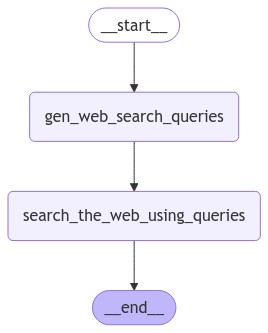

In [8]:
def get_web_search_graph_v2(display_graph: bool = False):
    # Define a new graph
    workflow = StateGraph(State)
    workflow.add_node("gen_web_search_queries", generate_web_search_queries_node)
    workflow.add_node("search_the_web_using_queries", get_search_the_web_using_queries_node)

    # Set the entrypoint as conversation
    workflow.add_edge(START, "gen_web_search_queries")
    workflow.add_edge("gen_web_search_queries", "search_the_web_using_queries")
    workflow.add_edge("search_the_web_using_queries", END)

    # Compile
    memory = MemorySaver()
    graph = workflow.compile(checkpointer=memory)
    if display_graph:
        display(Image(graph.get_graph().draw_mermaid_png()))
    return graph

graph = get_web_search_graph_v2(True)

In [9]:
def get_web_search_capability_v2(q: str, thread_id: str = "1"):
    g = get_web_search_graph_v2()
    # create a thread
    config = {"configurable": {
        "thread_id": thread_id,
    }}
    # start conversation
    input_message = HumanMessage(content=q)
    output = g.invoke({
        "attempts_count": 0,
        "messages": [input_message], 
        "num_web_search_queries": 3,
        "searches_summary": "",
        "searched_queries": []
    }, config) 
    return output["searches_summary"]

res = get_web_search_capability_v2(user_query)
res

[DEBUG] 
serp results for query leading yoghurt company stock symbol: [{'snippet': 'Chobani, LLC (the "Company" and, together with Chobani Finance Corporation, Inc., "Chobani"), a next generation food and beverage company originally known for its high-quality Greek yogurt, today ...', 'title': 'Chobani Announces Pricing of its $500 Million Private Offering of ...', 'link': 'https://finance.yahoo.com/news/chobani-announces-pricing-500-million-230400064.html'}, {'snippet': 'General Mills will sell its North American yogurt business to French dairy firms Groupe Lactalis and Sodiaal in a $2.1 billion deal, the Cheerios maker said on Thursday.', 'title': 'General Mills sells North American yogurt operations in $2 ... - CNN', 'link': 'https://www.cnn.com/2024/09/12/business/general-mills-yogurt-lactalis/index.html'}, {'snippet': 'General Mills, Inc. (NYSE: GIS) today announced that it has entered into definitive agreements to sell its North American Yogurt business to Lactalis and Sodiaal, t

"\n\n**Summary:**\n\n- General Mills sells North American yogurt operations to Lactalis and Sodiaal for $2.1 billion\n  - Lactalis acquires U.S. business, Sodiaal buys Canadian unit\n  - Deal aims to focus on stronger brands with higher margins\n  - Yoplait facing competition from Chobani and Danone's Dannon brand\n  - North American yogurt business contributed about $1.5 billion to General Mills' fiscal 2024 net sales\n\n**Largest Yogurt Manufacturer Ticker Symbols**\n\n- Danone S.A. (EPA: BN)\n- Chobani Inc. (Private)\n\n**Yum! Brands, Inc. (YUM) Stock Price & News**\n==============================================\n\n* Current price: $132.55\n* Market cap: 37.30B USD\n* P/E ratio: 24.20\n* Dividend yield: 2.02%\n* CEO: David Gibbs\n* Headquarters: Louisville, Kentucky, United States"

In [10]:
# write results to scratchpad.md
with open("scratchpad.md", "w") as f:
    f.write(res)
